# Models without Validation Set

In [1]:
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# for data processing for Tensorflow
import numpy as np
# for saving Tensorflow checkpoints
import os
# for loading and manipulating data
import pandas as pd
# for neural networks
import tensorflow as tf

review.json is 5.2 GB uncompressed with 6685900 lines corresponding to reviews and review metadata.  
It is too large to load completely into memory so I will load pieces of it as needed (pandas chunksize argument.)

# Filtering Data

In [2]:
# %%time #4min 38s
# # load data using chunksize option
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# # list to hold chunks after querying
# chunks = [chunk[(chunk.stars == 5.0) & (chunk.useful > 0)] for chunk in df_chunks]

# # dataframe of useful 5-star reviews
# df = pd.concat(chunks)

# # save csv for faster loading in the future
# df.to_csv('../data/useful_reviews.csv')

In [3]:
%%time
# load data from csv for a faster start
df = pd.read_csv('../data/useful_reviews.csv', index_col=0)
df_copy = df.copy()

C:\Users\K\Miniconda3\envs\tf-gpu-cuda10\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 11.3 s


In [4]:
# minimum number of useful votes to include
n = 30

# number of reviews in subset
print(df_copy[df_copy.useful >= n].shape[0])

# number of characters in subset
print(len(df_copy[df_copy.useful >= n].text.str.cat(sep='\n')))

# block of text to serve as model training data
text = df_copy[df_copy.useful >= n].text.str.cat(sep='\n')

# dataframe to allow for eda plots
df = df_copy[df_copy.useful >= n]

# subset for eda plotting about comment characteristics
text_length = df.text.str.len()

3733
5445501


1194239 reviews have been voted useful.  
591242 reviews have more than 1 useful vote.  
335812 reviews have more than 2 useful votes.  
211232 reviews have more than 3 useful votes.  
31020 reviews have more than 10 useful votes.  
3733 reviews have 30+ useful votes.*  
1812 reviews have 40+ useful votes.  
*For reduced computation time during this prototyping phase, I will use this reduced data set.

# EDA

Comments with at least 30 useful votes have a mean length of 1458 characters.  
Comments with at least 25 useful votes have a mean length of 1399 characters.

In [6]:
text_length.describe()

count    3733.000000
mean     1457.746852
std      1047.341406
min        56.000000
25%       683.000000
50%      1217.000000
75%      1962.000000
max      5000.000000
Name: text, dtype: float64

In [7]:
df.text[text_length == 66-10].values # shortest review. user and business id are hashed and requiring merging a different json.

array(['I received the product as expected and on time.  Thanks!'],
      dtype=object)

In [8]:
df.text[text_length == 5010-10].values # longest reviews. user and business id are hashed and requiring merging a different json.

array(['The ratings are not a lie and I have a new Top 3 favourite spot in Toronto. There\'s a lot of great things about Richmond Station.. but if there is one takeaway from my review, let it be this.  If you want a phenomenal meal, ask specifically for the chef pass and the chef tasting menu.  Not only is it a feast for your taste buds and eyes... it is a feast of all senses.  \n\nFrom the outside, you wouldnt think automatically a restaurant of this calibre and space would be hiding behind a simple window golden font of Richmond Station and a tiny signage with  simple words of \'Restaurant\'.  If you peered in, you\'d see an overflowing amount of people enjoying a lot of interesting dishes.  You\'ll also notice a lot of people coming in to only be sadly turned away.  \n\nThe space is warm and welcoming... there\'s no pretentious airs here.  It\'s quite different from my other 2 favourite higher end spots (Buca and Grey Gardens).  The atmosphere here is relaxed and if anything, more c

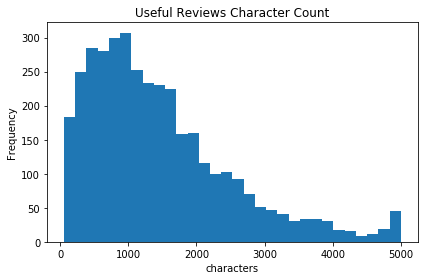

In [9]:
# plot distribution of character counts in useful reviews subset
text_length.plot(kind='hist', bins='fd', title='Useful Reviews Character Count')
plt.xlabel('characters')
plt.tight_layout()
plt.savefig('../img/useful_reviews_char_count.png')
plt.show()

# Data Pre-processing

In [9]:
# function that turns a sequence of length 100+1 into an input chunk (first 100 char) and target chunk (last 100 char).
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [10]:
# The unique characters in the file / number of output layer nodes.
vocab = sorted(set(text))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# converting text data into indices
text_as_int = np.array([char2idx[c] for c in text])

In [12]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# options for saving checkpoints
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Model Architectures

## Monday Model / Simple GRU

In [13]:
# The maximum length sentence we want for a single input in characters
seq_length = 100

# number of samples given sequence length
examples_per_epoch = len(text_as_int)//(seq_length+1)

# Create training, validation examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# combine consecutive elements of a data set into batches
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [14]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [15]:
# loss function for neural net
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [16]:
# Simple GRU based on https://www.tensorflow.org/tutorials/text/text_generation
def build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      # embedding layer. ?? what does it do ??
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
      # GRU layer. return full sequence to output layer
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
      # output is a matrix of shape(seq length, vocab size)
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [17]:
# function to generate strings of variable length
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = num_generate

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temperature

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
    
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [18]:
# more efficient than adding layers method
model_simplegru = build_model_simplegru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
# print model architecture table
model_simplegru.summary()
# model needs to be compiled
model_simplegru.compile(optimizer='adam', loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           37120     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 145)           148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')

In [ ]:
# # number of passes over the data
# EPOCHS=30
# # fit model
# history = model_simplegru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# Monday Model / SimpleGRU
Train for 842 steps  
Epoch 1/30  
842/842 [==============================] - 856s 1s/step - loss: 1.9921  
Epoch 2/30  
842/842 [==============================] - 858s 1s/step - loss: 1.4514  
Epoch 3/30  
842/842 [==============================] - 860s 1s/step - loss: 1.3572  
Epoch 4/30  
842/842 [==============================] - 836s 993ms/step - loss: 1.3080  
Epoch 5/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2742  
Epoch 6/30  
842/842 [==============================] - 837s 994ms/step - loss: 1.2484  
Epoch 7/30  
842/842 [==============================] - 830s 986ms/step - loss: 1.2276  
Epoch 8/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2109  
Epoch 9/30  
842/842 [==============================] - 831s 986ms/step - loss: 1.1973  
Epoch 10/30  
842/842 [==============================] - 825s 980ms/step - loss: 1.1865  
Epoch 11/30  
842/842 [==============================] - 822s 976ms/step - loss: 1.1778  
Epoch 12/30  
842/842 [==============================] - 820s 974ms/step - loss: 1.1712  
Epoch 13/30  
842/842 [==============================] - 817s 970ms/step - loss: 1.1671  
Epoch 14/30  
842/842 [==============================] - 816s 969ms/step - loss: 1.1644  
Epoch 15/30  
842/842 [==============================] - 808s 960ms/step - loss: 1.1634  
Epoch 16/30  
842/842 [==============================] - 818s 971ms/step - loss: 1.1635  
Epoch 17/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.1659  
Epoch 18/30  
842/842 [==============================] - 810s 962ms/step - loss: 1.1708  
Epoch 19/30  
842/842 [==============================] - 813s 965ms/step - loss: 1.1781  
Epoch 20/30  
842/842 [==============================] - 809s 961ms/step - loss: 1.1855  
Epoch 21/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 22/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 23/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.2193  
Epoch 24/30  
842/842 [==============================] - 806s 957ms/step - loss: 1.2577  
Epoch 25/30  
842/842 [==============================] - 814s 967ms/step - loss: 1.4293  
Epoch 26/30  
842/842 [==============================] - 803s 954ms/step - loss: 1.5127  
Epoch 27/30  
842/842 [==============================] - 804s 955ms/step - loss: 2.0795  
Epoch 28/30  
842/842 [==============================] - 802s 952ms/step - loss: 2.0716  
Epoch 29/30  
842/842 [==============================] - 801s 951ms/step - loss: 2.0330  
Epoch 30/30  
842/842 [==============================] - 794s 943ms/step - loss: 2.0158  

## Generating Text

### Checkpoint 15 (lowest training loss)

In [20]:
# rebuild model with batch size = 1
model_simplegru = build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')
# ?? ??
model_simplegru.build(tf.TensorShape([1, None]))
# print model architecture table
model_simplegru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            37120     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 145)            148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.6))
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.6))


We have a long line for my life and was in the restaurant with a "Cature" dish as well as the staff here is so strong, pretty much then this is a complete those process and a huge matter of french fries...

Whether you want your favorite system and don't let the tastiest section that we have in the back room.  I wanted to try some of the owners, and the turkey are always been well then you enjoy a ton of mixed and interesting inside of the bone marrow carry on the flavors. But seriously, there was a big business to the service, really fast and friendly. I have to say this place may just say this is a place to enjoy this was the only special disappointment. You may not say my personal favorite of the food is excellent.  I love this as it is certainly while there are a chance to try their stayed up to the strip and the store is super special. I was going to not go to the bar to grab a free pretty small salad. It was a great way to get yourself a far back to the stage.  

I am so off the

In [27]:
%%time
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.7))
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.7))


What they treat it was a good thing. Wow this is the place. It is always something that I haven't been in the large and major place. Through the exhibits to choose from an honest menu. 

When I was heading on a weekly accident for anything to do what this will definitely stay in Vegas. I saw a beer and I have a second opinion for a new car in the counter. Our group of tucked is incredibly tender and incredibly electronic in the San Francisco roll was the duct wall from the match.
What a cozy check and a house salad.  My favorites but I both surprised that this place deserves Brooklynt. The owners is the best I have made an appointment to take pictures and the food was wonderful.

The staff greeted us and the service is two acts for beer is a great way to start at the same time. 

With the Montreal starts for the sugar and thin cuirity is so diving!  
Everything was clean and prepared.  I was here twice in the area and had a big meal this is mall of course. It is impeccably the main st

In [28]:
%%time
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.8))
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.8))


Hooked Donuts :-)

I have to say I was valuating a doctor and I had seen that it still shit in the whole. 

If you drive this your typical center pain and then literally the one with many substitutes.  I am very hot & eaters, earning a drink and easy right spenches. I thought what was the right amount of six pieces of whiskey with a filling and side on the free once but this place is lost in the large size to read some of your persupering of town...immediately to do... Greenberg Railow display cards to find outside of the distance. However, owners was so class on the side the size of the individual is open to the distilling man masalah I sampled that about his restaurant and how excited we have a full and it tan early and so bigger than that. 

Very efficient and sweet. The sight special was this beamable dish being a huge herbal for a day d everything caught my alcoholic buning experience.
Right ourself be able to gain a taste of it all, the donuts in the package oh can be there.  Wh

## Tuesday Model / DeepGRU with Dropout

In [30]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [31]:
def build_model_deepgru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [32]:
model_deepgru = build_model_deepgru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

model_deepgru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (32, None, 256)           37120     
_________________________________________________________________
gru_2 (GRU)                  (32, None, 512)           1182720   
_________________________________________________________________
gru_3 (GRU)                  (32, None, 512)           1575936   
_________________________________________________________________
dense_2 (Dense)              (32, None, 145)           74385     
Total params: 2,870,161
Trainable params: 2,870,161
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_deepgru.load_weights('../training_checkpoints/deepGRU_training_checkpoints\\ckpt_15')

In [62]:
# # number of passes over the data
# EPOCHS=30
# # fit model
# history = model_deepgru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# Tuesday Model / DeepGRU with Dropout
Train for 1684 steps  
Epoch 1/30  
1684/1684 [==============================] - 1285s 763ms/step - loss: 1.8748  
Epoch 2/30  
1684/1684 [==============================] - 1213s 721ms/step - loss: 1.5296  
Epoch 3/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4742  
Epoch 4/30  
1684/1684 [==============================] - 1230s 730ms/step - loss: 1.4468  
Epoch 5/30  
1684/1684 [==============================] - 1230s 730ms/step - loss: 1.4291  
Epoch 6/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4176  
Epoch 7/30  
1684/1684 [==============================] - 1230s 731ms/step - loss: 1.4090  
Epoch 8/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4029  
Epoch 9/30  
1684/1684 [==============================] - 1207s 717ms/step - loss: 1.3982  
Epoch 10/30  
1684/1684 [==============================] - 1203s 714ms/step - loss: 1.3948  
Epoch 11/30  
1684/1684 [==============================] - 1195s 710ms/step - loss: 1.3922  
Epoch 12/30  
1684/1684 [==============================] - 1191s 707ms/step - loss: 1.3900  
Epoch 13/30  
1684/1684 [==============================] - 1175s 698ms/step - loss: 1.3889  
Epoch 14/30  
1684/1684 [==============================] - 1144s 679ms/step - loss: 1.3880  
Epoch 15/30  
1684/1684 [==============================] - 1216s 722ms/step - loss: 1.3876  
Epoch 16/30  
1684/1684 [==============================] - 1140s 677ms/step - loss: 1.3877  
Epoch 17/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.3883  
Epoch 18/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.3898  
Epoch 19/30  
1684/1684 [==============================] - 1194s 709ms/step - loss: 1.3910  
Epoch 20/30  
1684/1684 [==============================] - 1199s 712ms/step - loss: 1.3953  
Epoch 21/30  
1684/1684 [==============================] - 1138s 676ms/step - loss: 1.3958  
Epoch 22/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.4028  
Epoch 23/30  
1684/1684 [==============================] - 1129s 670ms/step - loss: 1.4123  
Epoch 24/30  
1684/1684 [==============================] - 1133s 673ms/step - loss: 1.4255  
Epoch 25/30  
1684/1684 [==============================] - 1124s 667ms/step - loss: 1.4752  
Epoch 26/30  
1684/1684 [==============================] - 1130s 671ms/step - loss: 1.5555  
Epoch 27/30  
1684/1684 [==============================] - 3373s 2s/step - loss: 1.6609  
Epoch 28/30  
1684/1684 [==============================] - 1137s 675ms/step - loss: 1.6540  
Epoch 29/30  
1684/1684 [==============================] - 1291s 767ms/step - loss: 1.6327  
Epoch 30/30  
1684/1684 [==============================] - 1379s 819ms/step - loss: 1.7405  

## Generating Text

### Checkpoint 15 (lowest training loss)

In [34]:
# rebuild model with batch size = 1
model_deepgru = build_model_deepgru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_deepgru.load_weights('../training_checkpoints/deepGRU_training_checkpoints\\ckpt_15')
# ?? ??
model_deepgru.build(tf.TensorShape([1, None]))
# print model architecture table
model_deepgru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            37120     
_________________________________________________________________
gru_4 (GRU)                  (1, None, 512)            1182720   
_________________________________________________________________
gru_5 (GRU)                  (1, None, 512)            1575936   
_________________________________________________________________
dense_3 (Dense)              (1, None, 145)            74385     
Total params: 2,870,161
Trainable params: 2,870,161
Non-trainable params: 0
_________________________________________________________________


In [41]:
%%time
print(generate_text(model_deepgru, start_string=u"\n", num_generate=1400, temperature=0.7))
print(generate_text(model_deepgru, start_string=u"\n", num_generate=1400, temperature=0.7))



He was a beautiful city and spicy and the owner which is heady and enjoyed in the sweet treat of bacon tuna and the products dinner and did not turn and not just don't know the rest of the spring sauce and strange of customers are not to come. The staff was very contacted I was really well with the mom.  We are smoking and soft and accommodating, and delicious. The gentleman is pretty lucky and knowledgeable and flavorful and friendly and good and great. 

I always beat the best and really good food.

Also the booze will definitely admit I am a friend where we were sincerthe shopped out of the entrance of the bud they are all the project as they also have the places on desert selling a short down and the bread here is stuffed with the coffee on the cashier and check in peanut and tender and great buttery change. He always decided on the party as much so I was pretty cool and completely much as it comes with the pork company and had the service reviews and potatoes and they really can